# Actor-Critic Algorithm
In this notebook, you'll code The Actor-Critic Algorithm from scratch: .

Actor-Critic algorithm is a *Policy-based method* that aims to reduce the variance of the Reinforce algorithm and train our agent faster and better by using a combination of Policy-Based and Value-Based methods


To test its robustness, we're going to train it in Cartpole-v1 environment

## Import the packages

In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gymnasium as gym

## Check if we have a GPU
- Let's check if we have a GPU `device:cuda0`

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Agent: Playing CartPole-v1 🤖
### The CartPole-v1 environment

> A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart.

So, we start with CartPole-v1. The goal is to push the cart left or right **so that the pole stays in the equilibrium.**

The episode ends if:
- The pole Angle is greater than ±12°
- Cart Position is greater than ±2.4
- Episode length is greater than 500

We get a reward 💰 of +1 every timestep the Pole stays in the equilibrium.

In [3]:
env_id = "CartPole-v1"
#env_id="LunarLander-v2"
# Create the env
env = gym.make(env_id)


# Get the state space and action space
s_size = env.observation_space.shape[0]
a_size = env.action_space.n

## Let's build the A2C algo


In [4]:
#Using a neural network to learn our actor (policy) parameters

class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):

        probs = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [16]:
#Using a neural network to learn state value
class Critic(nn.Module):
    #Takes in state
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()

        # two fully connected layers
        self.input_layer = nn.Linear(s_size, h_size)
        self.output_layer = nn.Linear(h_size, 1)

    def forward(self, x):

        #input layer
        x = self.input_layer(x)

        #activiation relu
        x = F.relu(x)

        #get state value
        state_value = self.output_layer(x)

        return state_value

# Building the parts of our algorithm #
The main steps for building a A2C Algo are:
1. Generates a trajectory
2. Compute the discounted returns
3. Standardization of the returns
4. Train critic network
5. Train actor network



In [24]:
 def generate_trajectory(actor, critic, max_t):
    saved_log_probs = []
    rewards = []
    state_values=[]
    
    state, _ = env.reset()
    for t in range(max_t):
        state=torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # Get action and log probability from actor
        action, log_prob = actor.act(state)
        
        # get the state value from th critic network
        state_val = critic(state)
        
        next_state, reward, terminnated, truncated, _ = env.step(action)
        
        # add te obtained results to their relative lists ==> saved_log_probs, rewards, state_values
        saved_log_probs.append(log_prob)
        rewards.append(reward)
        state_values.append(state_val)
        
        state=next_state
        
        if terminnated or truncated:
            break
    
    return  saved_log_probs, rewards, state_values

In [25]:
def computer_cumulative_reward(rewards, max_t,gamma):
    returns = deque(maxlen=max_t)
    n_steps = len(rewards)
    for t in range(n_steps)[::-1]:
        disc_return_t = (returns[0] if len(returns) > 0 else 0)
        returns.appendleft( rewards[t] + gamma * disc_return_t)
    return returns

In [26]:
def returns_standardization(returns):
    eps = np.finfo(np.float32).eps.item()
    ## eps is the smallest representable float, which is
    # added to the standard deviation of the returns to avoid numerical instabilities
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    return returns

In [27]:
def train_actor(actorOptimizer,saved_log_probs, returns,state_values):
    state_values= torch.stack(state_values).squeeze()

    #calculate Advantage for actor
    advantages = returns - state_values.detach()

    #convect the advantages to a tensor
    advantages = advantages.detach()

    actor_loss = []
    # compute the actor loss
    for log_prob, advantage in zip(saved_log_probs, advantages):
        actor_loss.append(-log_prob * advantage)


    actor_loss = torch.cat(actor_loss).sum()
    
    # Backpropagate actor
    actorOptimizer.zero_grad()
    actor_loss.backward()
    actorOptimizer.step()

In [28]:
def train_critic(criticOptimizer, returns,state_values):
    state_values= torch.stack(state_values).squeeze()
    
    # Calculate critic loss (MSE between predicted values and returns)
    critic_loss = F.mse_loss(state_values, returns)
    
    # Backpropagate crtic
    criticOptimizer.zero_grad()
    critic_loss.backward()
    criticOptimizer.step()

## Merge all functions into the Actor_Critic method ##

You will now see how the overall **A2C Algo** is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

In [29]:
def Actor_Critic(actor,critic, actorOptimizer,criticOptimizer, n_training_episodes, max_t, gamma, print_every):
    # Help us to calculate the score during the training
    scores_deque = deque(maxlen=100)
    scores = []
    
    for i_episode in range(1, n_training_episodes+1):
        # Generate an episode
        saved_log_probs, rewards, state_values = generate_trajectory(actor, critic, max_t)
        
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # calculate the return
        returns= computer_cumulative_reward(rewards,max_t,gamma)
        
        ## standardization of the returns is employed to make training more stable
        returns=returns_standardization(returns)
        
        # Train the Critic network
        train_critic(criticOptimizer, returns, state_values)
        
        # Train the Actor network
        train_actor(actorOptimizer, saved_log_probs, returns, state_values)
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
    return scores

##  Train it
- We're now ready to train our agent.
- But first, we define a variable containing all the training hyperparameters.
- You can change the training parameters (and should 😉)

In [30]:
cartpole_hyperparameters = {
    "h_size": 64,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [31]:
# Create actor and place it to the device
cartpole_actor = Actor(cartpole_hyperparameters["state_space"], 
                      cartpole_hyperparameters["action_space"], 
                      cartpole_hyperparameters["h_size"]).to(device)

cartpole_actorOptimizer = optim.Adam(cartpole_actor.parameters(), lr=cartpole_hyperparameters["lr"])

In [32]:
# Create critic and place it to the device
cartpole_critic = Critic(cartpole_hyperparameters["state_space"], 
                        cartpole_hyperparameters["h_size"]).to(device)

cartpole_criticOptimizer = optim.Adam(cartpole_critic.parameters(), lr=cartpole_hyperparameters["lr"])

In [34]:
print("Starting training...")
scores = Actor_Critic(cartpole_actor,
                   cartpole_critic,
                   cartpole_actorOptimizer,
                   cartpole_criticOptimizer,
                   cartpole_hyperparameters["n_training_episodes"],
                   cartpole_hyperparameters["max_t"],
                   cartpole_hyperparameters["gamma"],
                   100)
print("Training completed!")

Starting training...
Episode 100	Average Score: 327.13
Episode 200	Average Score: 402.22
Episode 300	Average Score: 482.03
Episode 400	Average Score: 476.87
Episode 500	Average Score: 494.42
Episode 600	Average Score: 497.20
Episode 700	Average Score: 494.34
Episode 800	Average Score: 500.00
Episode 900	Average Score: 468.74
Episode 1000	Average Score: 491.61
Training completed!


In [35]:
scores= pd.Series(scores, name="scores_Actor")
scores.describe()

count    1000.000000
mean      463.456000
std        96.042565
min        12.000000
25%       500.000000
50%       500.000000
75%       500.000000
max       500.000000
Name: scores_Actor, dtype: float64

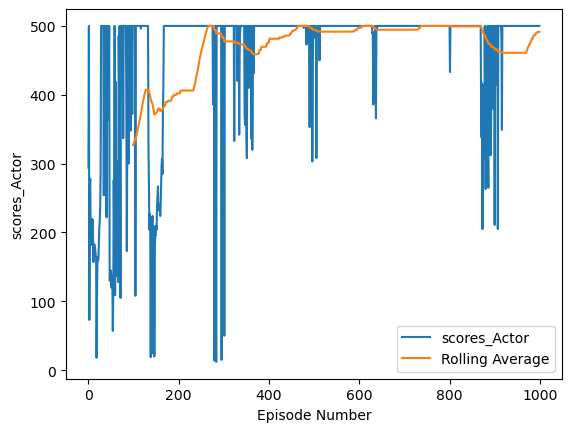

In [38]:
fig, ax = plt.subplots(1, 1)
_ = scores.plot(ax=ax, label="scores_Actor")
_ = (scores.rolling(window=100)
           .mean()
           .rename("Rolling Average")
           .plot(ax=ax))
ax.legend()
_ = ax.set_xlabel("Episode Number")
_ = ax.set_ylabel("scores_Actor")